In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from scipy import optimize, interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from scipy.optimize import basinhopping

In [2]:
# /data/df.pickleの読み込み
df = pd.read_pickle('../data/df.pickle')

df = df.dropna()

# データの分割
df_p1 = df[(df['started_at'] >= '2020-03-01') & (df['started_at'] < '2020-06-01')].dropna()
df_p2 = df[(df['started_at'] >= '2020-06-01') & (df['started_at'] < '2020-11-01')].dropna()
df_p3 = df[(df['started_at'] >= '2020-12-01') & (df['started_at'] < '2021-03-01')].dropna()
df_p4 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2023-10-01')].dropna()
df_p4_1 = df[(df['started_at'] >= '2021-03-01') & (df['started_at'] < '2022-01-01')].dropna()
df_p4_2 = df[(df['started_at'] >= '2022-01-01') & (df['started_at'] < '2023-10-01')].dropna()
df_left = pd.concat([df_p1, df_p2, df_p3, df_p4_1], axis=0)
df_right = pd.concat([df_p4_2], axis=0)

In [3]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='started_at')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]

        # node_listにはユニークなstart_station_idを追加
        node_list.append(len(df_tmp['start_station_id'].unique()))

        # edge_listにはdf_tmpの行数を追加
        edge_list.append(len(df_tmp))

        current_timestamp = next_timestamp

    # node_listとedge_listで0の値を削除
    node_list = np.array(node_list)
    edge_list = np.array(edge_list)
    timestamp = np.array(timestamp)
    active_node_list = node_list[node_list != 0]
    edge_list = edge_list[edge_list != 0]
    timestamp = timestamp[:len(node_list)]
    
    return active_node_list, edge_list, timestamp

In [4]:
node_left, edge_left, timestamp_left = return_nm(df_left)

In [5]:
# node_leftとedge_leftを組みにしてdf_leftを作成
df_left = pd.DataFrame({'node': node_left, 'edge': edge_left})
# df_leftのnodeを昇順にして並び替え
df_left = df_left.sort_values(by='node')
# インデックスを振り直す
df_left = df_left.reset_index(drop=True)
df_left.head()

,node,edge
0,106,190
1,136,221
2,173,312
3,215,368
4,217,494


In [6]:
# 正規化する
df_left["node_norm"] = df_left["node"] - df_left["node"].min() + 2
df_left["edge_norm"] = df_left["edge"] - df_left["edge"].min() + 1

# 一番最初の行を削除
df_left = df_left.drop(0)

# インデックスを振り直す
df_left = df_left.reset_index(drop=True)



In [7]:
df_left.head()  

,node,edge,node_norm,edge_norm
0,136,221,32,32
1,173,312,69,123
2,215,368,111,179
3,217,494,113,305
4,222,663,118,474


In [8]:
def model_uniform_2(x, Np):
    kappa = 8 * np.abs(x[0]) / (Np * (Np - 1))
    first = (1 - (kappa / 2))**Np
    second = 1 - first
    third = (2 / (kappa * Np)) * second
    fourth = 1 - third
    fifth = Np * fourth
    return fifth

In [19]:
print("+------------------+")
print("| Estimating       |")
print("+------------------+")

# 正規化したデータを使ってモデルを推定
xdata = df_left["edge_norm"].values
ydata = df_left["node_norm"].values

# モデルのパラメータを推定
popt, pcov = optimize.curve_fit(model_uniform_2, xdata, ydata, p0=[30])

# 推定したパラメータを表示
print("Estimated parameter:", popt[0])

params = popt[0]

+------------------+
| Estimating       |
+------------------+
Estimated parameter: 2865.8188681000665


In [25]:
df_left["edge_norm"].values

array([   32,   123,   179,   305,   474,   268,   456,   332,   593,
         395,   875,   454,   548,   509,   498,   718,   655,   923,
         691,  1086,   974,   900,   856,  1241,   987,  1355,  1327,
        2103,  1733,  1784,  1205,  1148,  1243,  1394,  1655,  2065,
        1229,  2077,  1762,  1932,  2296,  1417,  1760,  1808,  2397,
        1921,  2580,  1878,  1631,  2101,  2396,  2104,  1864,  2640,
        2498,  1855,  2470,  2775,  2100,  2833,  1781,  2632,  2077,
        2099,  1806,  2578,  2821,  2403,  2912,  2630,  2092,  2091,
        2868,  2171,  2693,  2104,  3497,  2531,  3185,  2815,  3146,
        3086,  2438,  3347,  3326,  3120,  3322,  2234,  2436,  3148,
        3489,  2544,  2843,  2963,  3458,  3163,  2653,  2918,  2998,
        3505,  2596,  3391,  3476,  2371,  3973,  3235,  2604,  2700,
        3719,  3152,  2681,  3865,  2417,  4310,  2966,  4266,  3332,
        3579,  3456,  4133,  3884,  3733,  3509,  3196,  3609,  4163,
        5077,  4600,

In [21]:
# 元の関数に代入する
Np_norm_hat = params
print("+------------------+")
kappa_norm_estimated = [(8 * df_left["edge_norm"][i]) / (Np_norm_hat * (Np_norm_hat - 1)) for i in range(len(df_left["edge_norm"]))]

# Eq8, 9
N_norm = []
M_norm = []
for i in range(len(kappa_norm_estimated)):
    N_norm.append( Np_norm_hat * ( 1 - (2/(kappa_norm_estimated[i] * Np_norm_hat)) * (1 - (1 - (kappa_norm_estimated[i]/2))**Np_norm_hat ) ) )
    M_norm.append( ((kappa_norm_estimated[i]* (Np_norm_hat)**2) - (kappa_norm_estimated[i]*Np_norm_hat)  * (1 / 8) ))

print("|      DONE        |")
print("+------------------+")
print("| Np: ", Np_norm_hat)
print("| N max: ", df_left["node_norm"].max())
print("| kappa: ", kappa_norm_estimated[0])
print("| N: ", N_norm[0])
print("| M: ", M_norm[0])
print("+------------------+")

+------------------+
|      DONE        |
+------------------+
| Np:  2865.8188681000665
| N max:  514
| kappa:  3.1181288628084945e-05
| N:  63.05802689036628
| M:  256.0781899346217
+------------------+


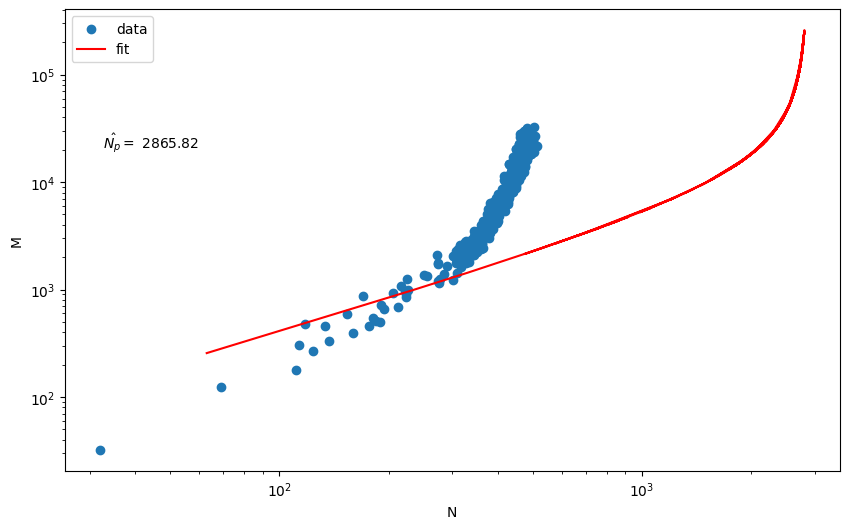

In [22]:
# 可視化
plt.figure(figsize=(10, 6))
plt.scatter(df_left["node_norm"], df_left["edge_norm"], label='data')
plt.plot(N_norm, M_norm, label='fit', color='red')
Np_norm_hat = round(Np_norm_hat, 2)
plt.text(0.05, 0.70, r'$\hat{N_{p}}=$ ' + str(Np_norm_hat), transform=plt.gca().transAxes)
plt.xlabel('N')
plt.ylabel('M')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='best')
plt.show()